In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch

import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, concatenate,Embedding,Reshape,LSTM,Bidirectional,SpatialDropout1D

from sklearn.model_selection import train_test_split
from sklearn import metrics

RANDOM_STATE=4222

In [2]:
df_train = pd.read_csv('./datasets/train.csv')
df_valid = pd.read_csv('./datasets/valid.csv')
df_test = pd.read_csv('./datasets/test.csv')

In [3]:
import gensim.downloader as api
import numpy as np

model = api.load("word2vec-google-news-300")

def get_sentence_vectors(sentence):
    tokens = sentence.split()
    vectors = [model[word] for word in tokens if word in model]
    
    if not vectors:
        return np.zeros(100)
    
    sentence_vector = np.mean(vectors, axis=0)[:100]
    return sentence_vector

In [4]:
def preprocess(df):
    cols_to_drop = ['Unnamed: 0','title_tokens', 'company_profile_tokens',
                'description_tokens', 'requirements_tokens', 'benefits_tokens']
    df.drop(columns=cols_to_drop, inplace=True)
    
    text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
    
    for col in text_cols:
        df[col] = df[col].apply(lambda x:get_sentence_vectors(x))
    
    return df

In [5]:
df_test = preprocess(df_test)
df_train = preprocess(df_train)
df_valid = preprocess(df_valid)

In [6]:
embeddings = ['title', 'company_profile', 'description', 'requirements', 'benefits']

In [7]:
y_train = df_train['fraudulent'].values
y_valid = df_valid['fraudulent'].values
y_test = df_test['fraudulent'].values

In [8]:
def convert_to_tensors(X_train_values):
    tensors = torch.from_numpy(np.vstack(X_train_values))
    return tf.constant(tensors.numpy(), dtype=tf.float32)

In [9]:
def get_tensors(df_col):
    return convert_to_tensors(df_col.values)

In [10]:
X_train_title = get_tensors(df_train['title'])
X_train_company_profile = get_tensors(df_train['company_profile'])
X_train_description = get_tensors(df_train['description'])
X_train_requirements = get_tensors(df_train['requirements'])
X_train_benefits = get_tensors(df_train['benefits'])

X_valid_title = get_tensors(df_valid['title'])
X_valid_company_profile = get_tensors(df_valid['company_profile'])
X_valid_description = get_tensors(df_valid['description'])
X_valid_requirements = get_tensors(df_valid['requirements'])
X_valid_benefits = get_tensors(df_valid['benefits'])

X_test_title = get_tensors(df_test['title'])
X_test_company_profile = get_tensors(df_test['company_profile'])
X_test_description = get_tensors(df_test['description'])
X_test_requirements = get_tensors(df_test['requirements'])
X_test_benefits = get_tensors(df_test['benefits'])

In [11]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=RANDOM_STATE)

X_train_title,y_train_resampled = smote.fit_resample(X_train_title,y_train)

X_train_company_profile,_ = smote.fit_resample(X_train_company_profile,y_train)

X_train_description,_ = smote.fit_resample(X_train_description,y_train)

X_train_requirements,_ = smote.fit_resample(X_train_requirements,y_train)

X_train_benefits,_ = smote.fit_resample(X_train_benefits,y_train)

In [12]:
def reshape_x(X_values):
    X_values = np.array(X_values)
    return X_values.reshape(X_values.shape[0], 1, X_values.shape[1])

def reshape_y(y_values):
    y_values = np.array(y_values)
    return y_values.reshape(y_values.shape[0], 1, 1)

In [13]:
X_train_title = reshape_x(X_train_title)
X_train_company_profile = reshape_x(X_train_company_profile)
X_train_description = reshape_x(X_train_description)
X_train_requirements = reshape_x(X_train_requirements)
X_train_benefits = reshape_x(X_train_benefits)

X_valid_title = reshape_x(X_valid_title)
X_valid_company_profile = reshape_x(X_valid_company_profile)
X_valid_description = reshape_x(X_valid_description)
X_valid_requirements = reshape_x(X_valid_requirements)
X_valid_benefits = reshape_x(X_valid_benefits)

X_test_title = reshape_x(X_test_title)
X_test_company_profile = reshape_x(X_test_company_profile)
X_test_description = reshape_x(X_test_description)
X_test_requirements = reshape_x(X_test_requirements)
X_test_benefits = reshape_x(X_test_benefits)

y_train_resampled = reshape_y(y_train_resampled)
y_valid = reshape_y(y_valid)
y_test = reshape_y(y_test)

In [14]:
embeddings.append('fraudulent')
X_train_non_text = df_train.drop(columns=embeddings).values
X_valid_non_text = df_valid.drop(columns=embeddings).values
X_test_non_text = df_test.drop(columns=embeddings).values

In [15]:
X_train_non_text

array([[ 0.        ,  0.        ,  1.        , ...,  0.17951219,
        -0.24205516, -0.17812327],
       [ 0.        ,  0.        ,  0.        , ...,  2.32860635,
        -0.79209685, -0.59968275],
       [ 0.        ,  0.        ,  1.        , ..., -0.96047205,
         1.37274615,  0.36834274],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.2587256 ,
         0.16500934, -0.59968275],
       [ 0.        ,  0.        ,  1.        , ..., -0.55062877,
        -0.21345972, -0.59968275],
       [ 1.        ,  0.        ,  1.        , ..., -0.01335523,
        -0.60370337, -0.44667227]])

In [16]:
X_train_non_text, _ = smote.fit_resample(X_train_non_text,y_train)

In [17]:
def create_neural_net(input_shape):
    model = Sequential([
        Dense(input_shape, activation='relu', input_shape=(input_shape,)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [18]:
def create_lstm(input_shape):
    model = Sequential([
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(64, input_shape=(1, 100))),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
model_title = create_lstm(100)
model_company_profile = create_lstm(100)
model_description = create_lstm(100)
model_requirements = create_lstm(100)
model_benefits = create_lstm(100)
model_non_text = create_neural_net(X_train_non_text.shape[1])

In [20]:
model_non_text.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 40)                1640      
                                                                 
 dense_6 (Dense)             (None, 1)                 41        
                                                                 
Total params: 1,681
Trainable params: 1,681
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_title.fit(X_train_title, y_train_resampled, validation_data=(X_valid_title, y_valid), epochs=10, verbose=2)
model_company_profile.fit(X_train_company_profile, y_train_resampled, validation_data=(X_valid_company_profile, y_valid), epochs=10, verbose=2)
model_description.fit(X_train_description, y_train_resampled, validation_data=(X_valid_description, y_valid), epochs=10, verbose=2)
model_requirements.fit(X_train_requirements, y_train_resampled, validation_data=(X_valid_requirements, y_valid), epochs=10, verbose=2)
model_benefits.fit(X_train_benefits, y_train_resampled, validation_data=(X_valid_benefits, y_valid), epochs=10, verbose=2)

Epoch 1/10
745/745 - 6s - loss: 0.5407 - accuracy: 0.7332 - val_loss: 0.5053 - val_accuracy: 0.7390 - 6s/epoch - 8ms/step
Epoch 2/10
745/745 - 2s - loss: 0.4878 - accuracy: 0.7636 - val_loss: 0.5298 - val_accuracy: 0.7241 - 2s/epoch - 3ms/step
Epoch 3/10
745/745 - 2s - loss: 0.4475 - accuracy: 0.7938 - val_loss: 0.4268 - val_accuracy: 0.8001 - 2s/epoch - 3ms/step
Epoch 4/10
745/745 - 2s - loss: 0.4108 - accuracy: 0.8158 - val_loss: 0.4116 - val_accuracy: 0.8095 - 2s/epoch - 3ms/step
Epoch 5/10
745/745 - 2s - loss: 0.3806 - accuracy: 0.8339 - val_loss: 0.3677 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 6/10
745/745 - 2s - loss: 0.3532 - accuracy: 0.8505 - val_loss: 0.3277 - val_accuracy: 0.8658 - 2s/epoch - 3ms/step
Epoch 7/10
745/745 - 2s - loss: 0.3300 - accuracy: 0.8632 - val_loss: 0.3403 - val_accuracy: 0.8658 - 2s/epoch - 3ms/step
Epoch 8/10
745/745 - 2s - loss: 0.3133 - accuracy: 0.8722 - val_loss: 0.3477 - val_accuracy: 0.8591 - 2s/epoch - 3ms/step
Epoch 9/10
745/745 - 2s 

In [22]:
concatenated = concatenate([model_title.output, 
                            model_company_profile.output, 
                            model_description.output, 
                            model_requirements.output, 
                            model_benefits.output,
                            model_non_text.output])


dense = Dense(32, activation='relu')(concatenated)
outputs = Dense(1, activation='sigmoid')(dense)

final_model = Model(inputs=[model_title.input, 
                    model_company_profile.input, 
                    model_description.input, 
                    model_requirements.input, 
                    model_benefits.input,
                    model_non_text.input], outputs=outputs)

In [23]:
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
final_model.fit([X_train_title,
                X_train_company_profile,
                X_train_description,
                X_train_requirements,
                X_train_benefits,
                X_train_non_text], y_train_resampled, epochs=10, batch_size=32,
                validation_data=([X_valid_title,
                                    X_valid_company_profile,
                                    X_valid_description,
                                    X_valid_requirements,
                                    X_valid_benefits,
                                    X_valid_non_text], y_valid))

Epoch 1/10
745/745 [==============================] - 20s 10ms/step - loss: 0.2217 - accuracy: 0.9304 - val_loss: 0.1277 - val_accuracy: 0.9508
Epoch 2/10
745/745 [==============================] - 5s 6ms/step - loss: 0.0928 - accuracy: 0.9669 - val_loss: 0.1070 - val_accuracy: 0.9564
Epoch 3/10
745/745 [==============================] - 5s 7ms/step - loss: 0.0740 - accuracy: 0.9726 - val_loss: 0.0815 - val_accuracy: 0.9709
Epoch 4/10
745/745 [==============================] - 5s 7ms/step - loss: 0.0589 - accuracy: 0.9801 - val_loss: 0.0912 - val_accuracy: 0.9668
Epoch 5/10
745/745 [==============================] - 5s 7ms/step - loss: 0.0518 - accuracy: 0.9813 - val_loss: 0.0817 - val_accuracy: 0.9691
Epoch 6/10
745/745 [==============================] - 5s 7ms/step - loss: 0.0424 - accuracy: 0.9858 - val_loss: 0.0684 - val_accuracy: 0.9754
Epoch 7/10
745/745 [==============================] - 5s 6ms/step - loss: 0.0384 - accuracy: 0.9878 - val_loss: 0.0925 - val_accuracy: 0.9642
Epoc

In [25]:
def get_confusion_matrix(actual, predicted, title):
    cf = metrics.confusion_matrix(actual, predicted)
    group_names = ['True Negative','False Positive','False Negative','True Positive'] 
    group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()] 

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    s = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues', xticklabels=['non fraud', 'fraud'], yticklabels=['non fraud', 'fraud'])
    s.set(xlabel='Predictions', ylabel='True Labels', title=title)
    return s

84/84 [==============================] - 3s 2ms/step


<AxesSubplot: xlabel='Predictions', ylabel='True Labels'>

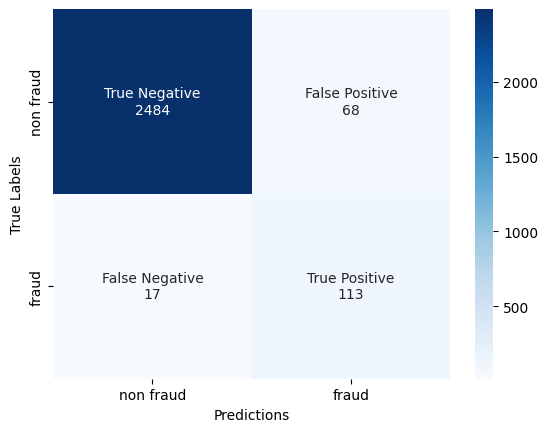

In [26]:
y_pred = final_model.predict([X_test_title,
                X_test_company_profile,
                X_test_description,
                X_test_requirements,
                X_test_benefits,
                X_test_non_text])

final_output = []
for x in y_pred:
    if x<=0.5:
        final_output.append([0])
    else:
        final_output.append([1])
get_confusion_matrix(y_test.reshape(2682), final_output, "")

In [27]:
metrics = {
    'Recall': [metrics.recall_score(y_test.reshape(2682),final_output)],
    'Precision': [metrics.precision_score(y_test.reshape(2682),final_output)],
    'F1-Score': [metrics.f1_score(y_test.reshape(2682),final_output)],
    'Accuracy': [metrics.accuracy_score(y_test.reshape(2682),final_output)],
    'ROC AUC': [metrics.roc_auc_score(y_test.reshape(2682),final_output)],
}

df_metrics = pd.DataFrame(metrics)
df_metrics

,Recall,Precision,F1-Score,Accuracy,ROC AUC
0,0.869231,0.624309,0.726688,0.968307,0.921293
